<h1 style="text-align:center;">Лабораторная работа №5</h1>

<h2 style="text-align:center;">Вычисление значения определенного интеграла</h2>

<h3 style="text-align:center;">Тулупов Николай Дмитриевич</h3>
<h3 style="text-align:center;">Б01-204</h3>

In [1040]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

### **Численное интегрирование таблично заданной функции.**
Цель: решить выбранную задачу перечисленными методами: 
1. Метод трапеций + уточнение по правилу Рунге
2. Формула Симпсона

<img src="images\lab_5_task_1.png" alt="drawing" width="650"/>

In [1041]:
# вариант в)
x = np.array([0.0,       0.15,     0.3,      0.45,     0.6,      0.75,     0.9,      1.05,    1.2     ])
f = np.array([1.000000, 1.007568, 1.031121, 1.073456, 1.140228, 1.242129, 1.400176, 1.660300, 2.143460])

In [1042]:
# Шаг сетки
h = (x[-1] - x[0]) / 8 #равномерный!

Используем метод Гаусса для решения СЛАУ из лабы 3.

In [1043]:
def norm3_vect(vect):
    return pow(sum(el**2 for el in vect), 0.5)

def matr_multipl(A, B):
    
    if A.shape[1] != B.shape[0]: return 
    AB = np.zeros((A.shape[0], B.shape[1]))
    for i in range(A.shape[0]):
        for j in range(B.shape[1]):
            for k in range(A.shape[1]):
                AB[i][j] += A[i][k] * B[k][j]
    
    return AB

def swap_rows(A, row1, row2): #функция для смены строк в матрице
    A[[row1, row2]] = A[[row2, row1]]

def swap_columns(A, col1, col2): #функция для смены столбцов в матрице
    A[:, [col1, col2]] = A[:, [col2, col1]]

def find_max_el(A, iter): #функция для поиска главного элемента матрицы A[iter,iter]
    size = len(A) - iter
    main_element = A[iter,iter]
    i_main, j_main = iter, iter

    for i in range(iter, size): 
        for j in range(iter, size):
            if abs(A[iter:, iter:][i][j]) > abs(main_element):
                i_main, j_main = i, j
                main_element = A[iter:, iter:][i][j]
    return main_element, i_main, j_main

def gauss(A, f):
    size = len(A)
    if A.shape[0] != A.shape[1]:
        print("Матрица не квадратная, решение невозможно!")
        return 
    x = np.arange(size) #массив с порядком корней (порядок будет меняться при перестановке столбцов)

    #прямой ход алгоритма - приводим матрицу A к верхнетреугольному виду
    for iter in range(len(A)):
        ''' Добавим в алгоритм проверку - если на какой-то итерации алгоритма возникла нулевая строка - ответ будет выражаться 
        через одну из переменных (её берем за константу, все остальные переменные будут выражены через нее)'''
        if (len(A) != sum(int(np.any(el)) for el in A)):
            '''Количество переменных превышает количество уравнений, решение не однозначн'''
            print("ERROR! Матрица не квадратная, решение невозможно!")
            return 
        
        main_el, i_main, j_main = find_max_el(A, iter) #максимальный элемент текущей матрицы и его местонахождение
        
        if (i_main != iter): #если элемент еще не в нулевой строке
            swap_rows(A, iter, i_main) #меняем в текущей матрице нулевую строку и строку, содержащую главный элемент            
            swap_rows(f, iter, i_main) #то же самое - в столбце решений       
            
        if (j_main != iter): #если элемент еще не в нулевом столбце
            swap_columns(A, iter, j_main) #меняем в текущей матрице нулевой столбец и столбец, содержащий главный элемент
            #swap_columns(x, iter, j_main) #то же самое - в строке порядка переменных
            x[iter], x[j_main] = x[j_main], x[iter]
        
        if main_el != 0:
            A[iter:, iter:][0] /= main_el #делим нулевую строку текущей матрицы на главный элемент
            f[iter] /= main_el #делим нулевую строку текущего столбца решений на главный элемент
        else:
            print("ERROR! main_el = 0")
            return
    
        for i in range(size - iter - 1):   
            f[i+iter+1] -= (f[iter] * A[iter:, iter:][i+1][0])
            #вычитаем из каждого элемента нулевой в текущем столбце решений, умноженный на нулевой элемент нужной строки - получаем в начале каждой строки единицу
            A[iter:, iter:][i+1] -=  (A[iter:, iter:][0] * A[iter:, iter:][i+1][0])
            #вычитаем из каждой строки нулевую, умноженную на нулевой элемент нужной строки - получаем в начале каждой строки единицу
        
    f[-1] /= A[-1][-1]
    A[size-1][size-1] = 1


    
    #обратный ход алгоритма
    U  = np.zeros((size, 1)) #столбец решений
    for i in range(size-1, -1, -1):
        U[i] = f[i]
        for j in range(i + 1, size):
            U[i] -= U[j] * A[i][j]

    #перестановка переменных в изначальном порядке
    ans = np.zeros((size, 1))
    for i in range(size):
        ans[int(x[i])] = U[i]
    
    return ans

Используем сплайн-интерполяцию из лабы 4.

In [1044]:
def cubic_spline_interpolation(x, y):
    
    n = len(x) - 1  # количество интервалов
    h = np.diff(x)  # длины интервалов

    # Вычисляем вектор правой части системы уравнений (f)
    f = np.zeros(n + 1)
    for i in range(1, n):
        f[i] = (3 / h[i] * (y[i + 1] - y[i]) - 3 / h[i - 1] * (y[i] - y[i - 1]))

    # Формируем матрицу A для решения системы уравнений
    A = np.zeros((n + 1, n + 1))
    b = np.zeros(n + 1)

    for i in range(1, n):
        A[i, i - 1] = h[i - 1]  # нижняя диагональ
        A[i, i] = 2 * (h[i - 1] + h[i])  # главная диагональ
        A[i, i + 1] = h[i]  # верхняя диагональ
        b[i] = f[i]

    # Граничные условия
    A[0, 0] = 1
    A[n, n] = 1
  
    # Решаем систему линейных уравнений для коэффициентов c
    c = gauss(A, b)

    # Вычисляем коэффициенты a, b, d
    a = y[:-1]
    b = np.zeros(n)
    d = np.zeros(n)

    for i in range(n):
        b[i] = (y[i + 1] - y[i]) / h[i] - h[i] * (2 * c[i][0] + c[i + 1][0]) / 3
        d[i] = (c[i + 1][0] - c[i][0]) / (3 * h[i])

    return a, b, c[:-1], d

def value_spline(x, a, b, c, d, xi):
    n = len(a)
    for i in range(n):
        if x[i] <= xi <= x[i + 1]:
            dx = xi - x[i]
            return a[i] + b[i] * dx + c[i] * dx**2 + d[i] * dx**3
    raise ValueError("xi вне диапазона x")


##### **1) Классический метод трапеций с уточнением по правилу Рунге.**

In [1045]:
# Метод трапеций
def trapezoid(x, f):
    n = len(x) - 1
    h = (x[-1] - x[0]) / n
   
    integral = h * (0.5 * f[0] + np.sum(f[1:-1]) + 0.5 * f[-1])
    return integral

In [1046]:
# правило Рунге
def runge(I_h, I_2h, p = 2):
    return I_h + (I_h - I_2h) / (2**p - 1)

In [1047]:
# метод трапеций с уточнением по правилу Рунге
def trapezoid_runge(x, y):

    I_h = trapezoid(x, y)
    I_2h = 0

    a, b, c, d = cubic_spline_interpolation(x, y)

    for i in range(len(x) - 1):
        x_val = (x[i] + x[i+1]) / 2
        y_val = value_spline(x, a, b, c, d, x_val)

        I_2h += 0.5 * (y_val + y[i]) * (x_val - x[i])
        I_2h += 0.5 * (y_val + y[i+1]) * (x[i+1] - x_val)
    
    return (runge(I_h, I_2h, p = 2))

In [1048]:
#посмотрим на результаты

I_trap = float(trapezoid(x, f))
print(f"классический метод трапеций:                  {I_trap:.7f}" )

I_trap_runge = float(trapezoid_runge(x, f).item())
print(f"метод трапеций с уточнением по правилу Рунге: {I_trap_runge:.7f}" )

классический метод трапеций:                  1.5190062
метод трапеций с уточнением по правилу Рунге: 1.5201665


##### **2) Метод Симпсона.**

Для приближённого вычисления определённого интеграла на равномерной сетке используется **метод Симпсона**:

$$
\int_a^b f(x) \, dx \approx \frac{h}{3} \left[ f(x_0) + 4f(x_1) + 2f(x_2) + 4f(x_3) + \dots + 2f(x_{n-2}) + 4f(x_{n-1}) + f(x_n) \right],
$$

где:

- $ x_0, x_1, \dots, x_n $ — узлы равномерного разбиения на отрезке $ [a, b] $
- $ h = \frac{b - a}{n} $ — шаг разбиения,
- $ n $ — чётное количество подотрезков,
- $ f(x_0), f(x_1), \dots, f(x_n)$ — значения функции в узлах.

**Коэффициенты 4 и 2** чередуются:
- $ 4 \cdot f(x_i) $ для нечётных узлов $ x_1, x_3, \dots $,
- $ 2 \cdot f(x_i) $ для чётных узлов $ x_2, x_4, \dots $,
- $ f(x_0) $ и $ f(x_n) $ учитываются с коэффициентом 1 (границы отрезка).

Формула применяется для чётного $ n $, так как каждых два подотрезка аппроксимируются одной параболой.


In [1049]:
#метод Симпсона
def simpson(x, y):
    
    num_intervals = len(x) - 1  # Количество подотрезков (должно быть чётным для метода Симпсона)
    
    if num_intervals % 2 != 0:
        raise ValueError("Метод Симпсона требует чётное количество подотрезков.")

    step_size = (x[-1] - x[0]) / num_intervals  # Шаг разбиения
    integral_sum = y[0] + y[-1]  # Начинаем с первого и последнего значений функции

    # Суммируем 4 * f(x_i) для нечётных индексов (средние точки на каждом подотрезке)
    for i in range(1, num_intervals, 2):
        integral_sum += 4 * y[i]
    
    # Суммируем 2 * f(x_i) для чётных индексов (внутренние точки на границах подотрезков)
    for i in range(2, num_intervals, 2):
        integral_sum += 2 * y[i]
    
    # Умножаем сумму на шаг / 3 для получения окончательного значения интеграла
    integral = (step_size / 3) * integral_sum
    
    return integral

In [1050]:
print(f"классический метод трапеций:                  {I_trap:.7f}" )
print(f"метод трапеций с уточнением по правилу Рунге: {I_trap_runge:.7f}" )
I_simpson = float(simpson(x, f))
print(f"метод Симпсона:                               {I_simpson:.7f}" )

классический метод трапеций:                  1.5190062
метод трапеций с уточнением по правилу Рунге: 1.5201665
метод Симпсона:                               1.5110161


### **Численное интегрирование быстро осциллирующей функции.**

Вариант б) :  $\int_1^2 cos(100x)ln(x)dx$

<img src="images\lab_5_task_2.png" alt="drawing" width="650"/>

Посмотрим, как выглядит такая функция:

<img src="images\rapidly_oscillating.png" alt="drawing" width="800"/>

Хотя зачем нам desmos, мы ведь написали интерполяцию!

Нарисуем эту функцию - возьмем за отсчеты 100 точек, построим кубический сплайн и посчитаем его знечение в 1000 точках.

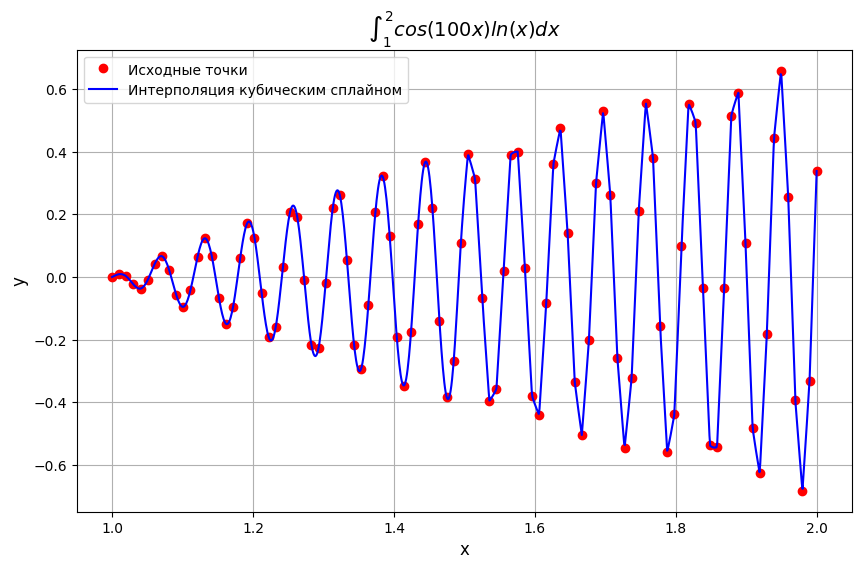

In [1051]:
x = np.linspace(1, 2, 100)
y = np.cos(100*x)*np.log(x)

plt.figure(figsize=(10, 6))

#исходные данные - заданные для интерполяции точки
plt.plot(x, y, '.', color='red')

# Строим сплайн
a, b, c, d = cubic_spline_interpolation(x, y)



# Оцениваем значение сплайна
x_dense = np.linspace(1, 2, 1000)
y_dense = [value_spline(x, a, b, c, d, xi) for xi in x_dense]


plt.plot(x, y, 'o', label="Исходные точки", color = "red")
plt.plot(x_dense, y_dense, label="Интерполяция кубическим сплайном", color = "blue")


plt.title('$\int_1^2 cos(100x)ln(x)dx$', fontsize=14)
plt.xlabel('x', fontsize=12)
plt.ylabel('y', fontsize=12)

plt.legend()
plt.grid(True)
plt.show()

In [1052]:
# Функция для интегрирования
def f(x):
    return np.cos(100 * x) * np.log(x)

In [1053]:
# Создаём сетку
a, b = 1, 2  # Пределы интегрирования
n = 1000  # Количество узлов (чем больше, тем точнее для осциллирующих функций)

x = np.linspace(a, b, n + 1)
y = f(x)

I_trap = float(trapezoid(x, y).item())

Так как в данном случае функция задана аналитически, а не таблично, можем уточнить значение интеграла, посчитанного методом трапеций, правилом Рунге без применения громоздкой функции trapezoid runge, а просто подставив в формулу Рунге знечение уже посчитанного интеграла и интеграла, посчитанного для в 2 раза более частой сетки.


In [1054]:

# Уменьшаем шаг в 2 раза и пересчитываем
x_2 = np.linspace(a, b, 2 * n + 1)
y_2 = f(x_2)
I_trap_2 = trapezoid(x_2, y_2)

# Уточняем результат по правилу Рунге
I_runge = runge(I_trap_2, I_trap)

I_simpson = float(simpson(x, y))

print(f"классический метод трапеций:                       {I_trap:.7f}" )
print(f"классический метод трапеций с увеличенной сеткой:  {I_trap_2:.7f}" )
print(f"метод трапеций с уточнением по правилу Рунге:      {I_runge:.7f}" )
print(f"метод Симпсона:                                    {I_simpson:.7f}" )

классический метод трапеций:                       -0.0061098
классический метод трапеций с увеличенной сеткой:  -0.0061136
метод трапеций с уточнением по правилу Рунге:      -0.0061148
метод Симпсона:                                    -0.0061148


Убедимся в правильности ответа с помощью Wolfram

<img src="images\answer2.png" alt="drawing" width="650"/>

Все достаточно точно!

### **Численное интегрирование быстро осциллирующей таблично заданной функции.**

Вариант в) : 

<img src="images\lab_5_task_3.png" alt="drawing" width="650"/>

In [1055]:
# перепишем табличные значения функции
x = np.array([0.0,     1.7,    3.4,    5.1,    6.8])
y = np.array([0.0000,  1.3038, 1.8439, 2.2583, 2.6077])

Нарисуем интерполяцию заданной функции.

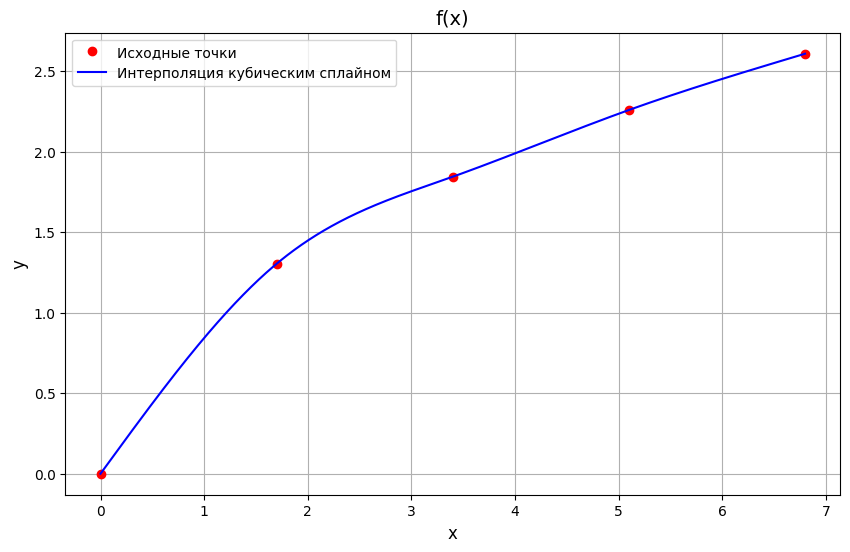

In [1056]:
plt.figure(figsize=(10, 6))

#исходные данные - заданные для интерполяции точки
plt.plot(x, y, '.', color='red')

# Строим сплайн
a, b, c, d = cubic_spline_interpolation(x, y)

# Оцениваем значение сплайна
x_dense = np.linspace(min(x), max(x), 10000)
y_dense = [value_spline(x, a, b, c, d, xi) for xi in x_dense]

plt.plot(x, y, 'o', label="Исходные точки", color = "red")
plt.plot(x_dense, y_dense, label="Интерполяция кубическим сплайном", color = "blue")


plt.title('f(x)', fontsize=14)
plt.xlabel('x', fontsize=12)
plt.ylabel('y', fontsize=12)

plt.legend()
plt.grid(True)
plt.show()

На самом деле может оказаться для функций с большим количеством отсчетов, что численное интегрирование по интерполяции бессмысленно - ведь в зависимости от выбранного метода интерполяции и его параметров можно получить кривые совершенно разных форм, интегрирование которых приведет к очень разным значениям. 

В данном случае интерполяция справляется отлично, ведь точек немного и функция ведет себя предсказуемо. Но в условии не даром написано, что сплайн будет для аппроксимации, а не для интерполяции. Аппроксимированная кривая будет отражать общий вид таблично заданной функции и ее интегрирование будет иметь смысл. Тем более для таблично заданной функции это единственный способ найти определенный интеграл.

Немного изменим функцию сплайна - для аппроксимации.

Вместо жесткого условия 
$𝑆(𝑥_𝑖)=𝑦_𝑖$ для всех $𝑖$, мы минимизируем сумму квадратов отклонений:
$$∑_{𝑖=0}^𝑛 (𝑆(𝑥_𝑖)−𝑦_𝑖)^2 → min$$
Это приводит к системе линейных уравнений, где коэффициенты сплайна подбираются приближённо - для получения коэффициентов сплайна используем методы МНК.

In [1057]:
# Функция для аппроксимации кубическим сплайном методом наименьших квадратов
def cubic_spline_approximation(x, y):
    n = len(x) - 1  # Количество интервалов
    h = np.diff(x)  # Длины интервалов

    f = np.zeros(n + 1)

    # Матрица A и вектор правой части b 
    A = np.zeros((n + 1, n + 1))
    b = np.zeros(n + 1)

    for i in range(1, n):
        f[i] = (3 / h[i] * (y[i + 1] - y[i]) - 3 / h[i - 1] * (y[i] - y[i - 1]))

    # Заполнение матрицы A (сглаживание)
    for i in range(1, n):
        A[i, i - 1] = h[i - 1]
        A[i, i] = 2 * (h[i - 1] + h[i])
        A[i, i + 1] = h[i]
        b[i] = f[i] 

    # Граничные условия (естественный сплайн)
    A[0, 0] = 1
    A[n, n] = 1

    # Решаем систему линейных уравнений
    c = gauss(A, b)

    # Вычисляем коэффициенты a, b, d
    a = y[:-1]
    b_coef = np.zeros(n)
    d = np.zeros(n)

    for i in range(n):
        b_coef[i] = ((y[i + 1] - y[i]) / h[i] - h[i] * (2 * c[i] + c[i + 1]) / 3).item()
        d[i] = ((c[i + 1] - c[i]) / (3 * h[i])).item()

    return a, b_coef, c[:-1], d

# Функция для вычисления значения аппроксимирующего сплайна в точке xi
def value_spline_approximation(x, a, b, c, d, xi):
    n = len(a)
    for i in range(n):
        if x[i] <= xi <= x[i + 1]:
            dx = xi - x[i]
            return a[i] + b[i] * dx + c[i] * dx**2 + d[i] * dx**3
    raise ValueError("xi вне диапазона x")

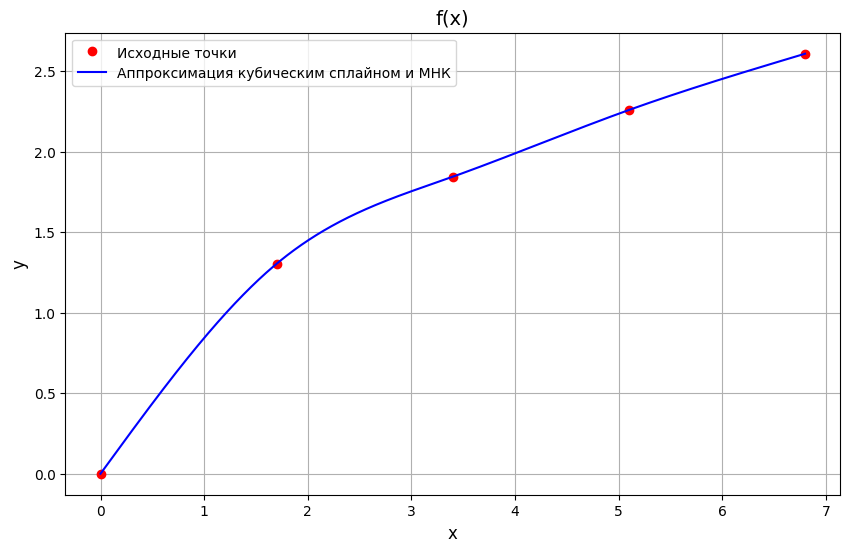

In [1058]:
plt.figure(figsize=(10, 6))

#исходные данные - заданные для интерполяции точки
plt.plot(x, y, '.', color='red')

# Строим аппроксимацию кубическим сплайном
a, b, c, d = cubic_spline_approximation(x, y)

# Оцениваем значение сплайна
x_dense = np.linspace(min(x), max(x), 10000)
y_dense = [value_spline(x, a, b, c, d, xi) for xi in x_dense]


plt.plot(x, y, 'o', label="Исходные точки", color = "red")
plt.plot(x_dense, y_dense, label="Аппроксимация кубическим сплайном и МНК", color = "blue")


plt.title('f(x)', fontsize=14)
plt.xlabel('x', fontsize=12)
plt.ylabel('y', fontsize=12)

plt.legend()
plt.grid(True)
plt.show()

Конечно, как я уже сказал, в данном случае разница незаметна, однако если бы мы взяли таблично заданную быстро осциллирующую функцию, интерполяция бы в интегрировании не помогла.
Теперь посчитаем интеграл парочкой написанных методов.

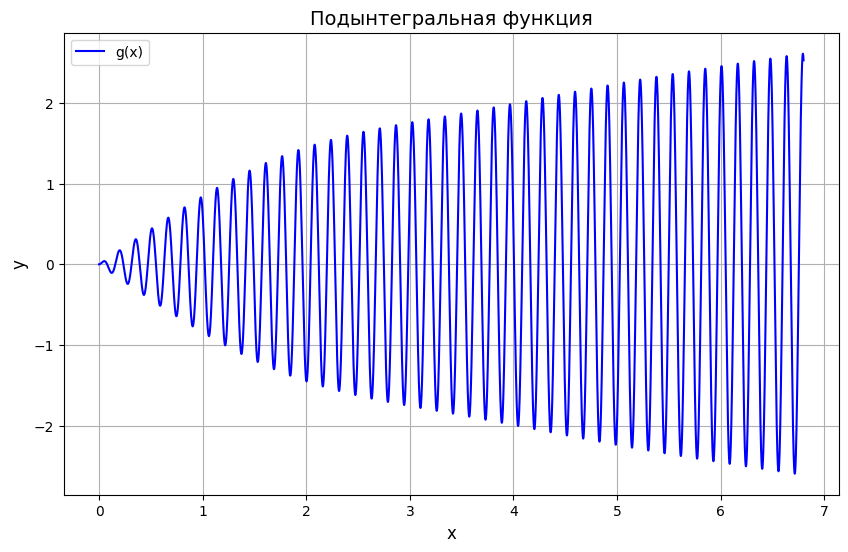

In [1059]:
k = 40
x_int = np.linspace(min(x), max(x), 10000)
y_int = np.zeros(len(x_int))

for i in range(len(x_dense)):
    y_int[i] = y_dense[i][0]
    y_int[i] = y_int[i] * np.sin(k*x_int[i])


plt.figure(figsize=(10, 6))
plt.plot(x_int, y_int, label="g(x)", color = "blue")

plt.title('Подынтегральная функция', fontsize=14)
plt.xlabel('x', fontsize=12)
plt.ylabel('y', fontsize=12)

plt.legend()
plt.grid(True)
plt.show()

In [1060]:

I_trap = float(trapezoid(x_int, y_int).item())
print(f"классический метод трапеций:        {I_trap:.7f}" )

#вспомним - метод Симпсона работает лишь для четного количества подотрезков
# так что в ином случае просто удалим последнюю точку, их у нас 10000
if len(x_int) % 2 == 0:  # Проверяем количество точек
    x_int = x_int[:-1]
    y_int = y_int[:-1]


I_simpson = float(simpson(x_int, y_int))

print(f"метод Симпсона:                     {I_simpson:.7f}" )

классический метод трапеций:        0.0163872
метод Симпсона:                     0.0146652


Как бы проверить? Выведем коэффициенты полинома, которые выдал сплайн



In [1061]:

def print_spline_polynomials(x, a, b, c, d):
    n = len(a)
    for i in range(n):
        print(f"Полином на отрезке [{x[i]}, {x[i+1]}]:")
        print(f"S_{i}(x) = {a[i]:.6f} + {b[i]:.6f}*(x - {x[i]:.6f}) + {c[i][0]:.6f}*(x - {x[i]:.6f})^2 + {d[i]:.6f}*(x - {x[i]:.6f})^3\n")

# Вызов функции
print_spline_polynomials(x, a, b, c, d)

Полином на отрезке [0.0, 1.7]:
S_0(x) = 0.000000 + 0.882445*(x - 0.000000) + 0.000000*(x - 0.000000)^2 + -0.039967*(x - 0.000000)^3

Полином на отрезке [1.7, 3.4]:
S_1(x) = 1.303800 + 0.535933*(x - 1.700000) + -0.203830*(x - 1.700000)^2 + 0.044389*(x - 1.700000)^3

Полином на отрезке [3.4, 5.1]:
S_2(x) = 1.843900 + 0.230958*(x - 3.400000) + 0.022554*(x - 3.400000)^2 + -0.008835*(x - 3.400000)^3

Полином на отрезке [5.1, 6.8]:
S_3(x) = 2.258300 + 0.231037*(x - 5.100000) + -0.022507*(x - 5.100000)^2 + 0.004413*(x - 5.100000)^3



И забьем теперь 4 интеграла в онлайн решатель https://mathdf.com/int/ru/

<img src="images\ans3_1.png" alt="drawing" width="550"/>

<img src="images\ans3_2.png" alt="drawing" width="650"/>

<img src="images\ans3_3.png" alt="drawing" width="650"/>

<img src="images\ans3_4.png" alt="drawing" width="650"/>


In [1062]:
I_online = -0.014650102 + 0.042774022 + 0.02719982 - 0.038935428

In [1063]:
print(f"классический метод трапеций:        {I_trap:.7f}" )
print(f"метод Симпсона:                     {I_simpson:.7f}" )
print(f"онлайн решатель:                    {I_online:.7f}" )


классический метод трапеций:        0.0163872
метод Симпсона:                     0.0146652
онлайн решатель:                    0.0163883
